In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import random
from itertools import combinations
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import copy
from tqdm import tqdm
from scipy.spatial.distance import cosine

## Reading the dataset.
Please change the path of the dataset

In [7]:
faces = {}
dataset_path = '/kaggle/input/iiitb-faces/IIITB-FACES'
sub_folders = os.listdir(dataset_path)
for sub_folder in sub_folders:
    image_paths = os.listdir(os.path.join(dataset_path, sub_folder))
    for image_path in image_paths:
        image_path_actual = os.path.join(dataset_path, sub_folder, image_path)
        faces[image_path_actual] = cv2.resize(cv2.cvtColor(cv2.imread(image_path_actual), cv2.COLOR_BGR2GRAY), (400, 400))

In [8]:
dataset_dict = {}
for key in faces.keys():
    class_key = str(key.split('/')[5])
    if class_key in list(dataset_dict.keys()):
        dataset_dict[class_key] = dataset_dict[class_key] + [Image.open(key).convert('L').resize((128, 128))]
    else:
        dataset_dict[class_key] = [Image.open(key).convert('L').resize((128, 128))]

## Making the train-test split of images

In [9]:
dataset_dict_test_split = {}
dataset_keys = list(dataset_dict.keys())
dataset_dict_test_split[str(dataset_keys[len(dataset_keys)-1])] = dataset_dict[str(dataset_keys[len(dataset_keys)-1])]
dataset_dict_new = {}
for i in range(len(dataset_keys)-1):
    dataset_dict_new[dataset_keys[i]] = dataset_dict[dataset_keys[i]]
dataset_dict_whole = copy.deepcopy(dataset_dict)
dataset_dict = copy.deepcopy(dataset_dict_new)
def split_dataset(dataset_dict, test_ratio=0.2):
    train_data = {}
    test_data = {}

    for class_name, image_paths in dataset_dict.items():
        num_samples = len(image_paths)
        num_test_samples = int(test_ratio * num_samples)
        random.shuffle(image_paths)
        train_data[class_name] = image_paths[:-num_test_samples]
        test_data[class_name] = image_paths[-num_test_samples:]

    return train_data, test_data

train_data_dict, test_data_dict = split_dataset(dataset_dict)

In [10]:
train_images = []
for key in train_data_dict.keys():
    for image_sample in train_data_dict[key]:
        train_images.append(np.array(image_sample).reshape(-1))
train_images = np.array(train_images)

## Fitting the PCA model on training images

In [11]:
n_components = 128  # Number of top features
pca = PCA(n_components=n_components)
pca.fit(train_images)

PCA(n_components=128)

## Making inference on the PCA Model

In [12]:
#Performing PCA transform and saving it on all training images
train_data_dict_with_PCA = {}
for key in tqdm(train_data_dict.keys()):
    image_list = []
    for image_sample in train_data_dict[key]:
        image_list.append([image_sample, pca.transform(np.array(image_sample).reshape(1, -1))])
    train_data_dict_with_PCA[key] = image_list

#Performing PCA transform and saving it on all in-sample testing images
test_data_dict_with_PCA = {}
for key in tqdm(test_data_dict.keys()):
    image_list = []
    for image_sample in test_data_dict[key]:
        image_list.append([image_sample, pca.transform(np.array(image_sample).reshape(1, -1))])
    test_data_dict_with_PCA[key] = image_list

#Performing PCA transform and saving it on all out-of-sample testing images   
test_data_dict_with_PCA_out_of_sample = {}
for key in tqdm(dataset_dict_test_split.keys()):
    image_list = []
    for image_sample in dataset_dict_test_split[key]:
        image_list.append([image_sample, pca.transform(np.array(image_sample).reshape(1, -1))])
    test_data_dict_with_PCA_out_of_sample[key] = image_list

#Making Pairs of data from the training split
train_dataset = []
train_class_pairs = []
for class1 in train_data_dict_with_PCA.keys():
    for class2 in train_data_dict_with_PCA.keys():
        train_class_pairs.append([class1, class2])
for class1, class2 in tqdm(train_class_pairs):
    for img1 in train_data_dict_with_PCA[class1]:
        for img2 in train_data_dict_with_PCA[class2]:
            if class1 == class2:
                label = 1
            else:
                label = 0
            train_dataset.append([img1[0], img2[0], label, (1 - cosine(img1[1].reshape(-1), img2[1].reshape(-1)))])   

# Making pairs of data from the testing split. 
# We call this is as in-sample testing pairs, because while fitting the PCA Model,
# The Model has looked at least 1 image of the same person    
test_dataset = []
test_class_pairs = []
for class1 in test_data_dict_with_PCA.keys():
    for class2 in dataset_dict.keys():
        test_class_pairs.append([class1, class2])
for class1, class2 in tqdm(test_class_pairs):
    for img1 in test_data_dict_with_PCA[class1]:
        for img2 in train_data_dict_with_PCA[class2]:
            # label = int(class1 == class2)  # 1 if same class, else 0
            if class1 == class2:
                label = 1
            else:
                label = 0
            test_dataset.append([img1[0], img2[0], label, (1 - cosine(img1[1].reshape(-1), img2[1].reshape(-1)))])   
        for img2 in test_data_dict_with_PCA[class2]:
            # label = int(class1 == class2)  # 1 if same class, else 0
            if class1 == class2:
                label = 1
            else:
                label = 0
            test_dataset.append([img1[0], img2[0], label, (1 - cosine(img1[1].reshape(-1), img2[1].reshape(-1)))]) 

# Making pairs of data from the reserved testing split. 
# We call this is as out-of-sample testing pairs, because while fitting the PCA Model,
# The Model hasn't looked at even 1 image of the same person    
# Test of generalisability.
test_dataset_out_of_sample = []
test_class_pairs_out_of_sample = []
for class1 in test_data_dict_with_PCA_out_of_sample.keys():
    for class2 in dataset_dict_whole.keys():
        test_class_pairs_out_of_sample.append([class1, class2])
for class1, class2 in tqdm(test_class_pairs_out_of_sample):
    for img1 in test_data_dict_with_PCA_out_of_sample[class1]:
        if class2 in list(train_data_dict_with_PCA.keys()):
            for img2 in train_data_dict_with_PCA[class2]:
                # label = int(class1 == class2)  # 1 if same class, else 0
                if class1 == class2:
                    label = 1
                else:
                    label = 0
                test_dataset_out_of_sample.append([img1[0], img2[0], label, (1 - cosine(img1[1].reshape(-1), img2[1].reshape(-1)))])
        if class2 in list(test_data_dict_with_PCA.keys()):
            for img2 in test_data_dict_with_PCA[class2]:
                # label = int(class1 == class2)  # 1 if same class, else 0
                if class1 == class2:
                    label = 1
                else:
                    label = 0
                test_dataset_out_of_sample.append([img1[0], img2[0], label, (1 - cosine(img1[1].reshape(-1), img2[1].reshape(-1)))])
        if class2 in list(test_data_dict_with_PCA_out_of_sample.keys()):
            for img2 in test_data_dict_with_PCA_out_of_sample[class2]:
                # label = int(class1 == class2)  # 1 if same class, else 0
                if class1 == class2:
                    label = 1
                else:
                    label = 0
                test_dataset_out_of_sample.append([img1[0], img2[0], label, (1 - cosine(img1[1].reshape(-1), img2[1].reshape(-1)))]) 

100%|██████████| 49/49 [00:00<00:00, 54.94it/s]


## Let's visualise our data
This serves as motivation for learning an appropriate threshold

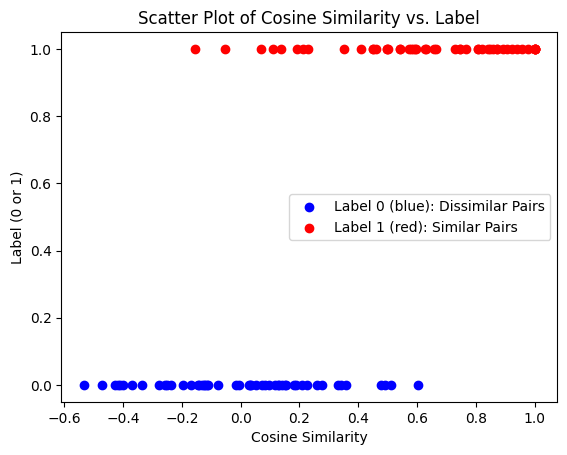

In [13]:
ds = train_dataset

data_label_0 = [item for item in ds if item[2] == 0]
data_label_1 = [item for item in ds if item[2] == 1]

sampled_data_0 = random.sample(data_label_0, 50)
sampled_data_1 = random.sample(data_label_1, 50)

variables_0 = [item[3] for item in sampled_data_0]
variables_1 = [item[3] for item in sampled_data_1]

# Create scatter plots for each label with different colors and labels
plt.scatter(variables_0, [0] * 50, c='b', label='Label 0 (blue): Dissimilar Pairs')
plt.scatter(variables_1, [1] * 50, c='r', label='Label 1 (red): Similar Pairs')

# Add labels and a title
plt.xlabel('Cosine Similarity')
plt.ylabel('Label (0 or 1)')
plt.title('Scatter Plot of Cosine Similarity vs. Label')

# Add legends for each label
plt.legend(['Label 0 (blue): Dissimilar Pairs', 'Label 1 (red): Similar Pairs'])

# Show the plot
plt.show()

## Lets Learn the threshold now, heuristically

Some necesarry pre-processing

In [14]:
train_similar = []
train_dissimilar = []
for img1, img2, label, similarity in train_dataset:
    if label == 1:
        train_similar.append(similarity)
    else:
        train_dissimilar.append(similarity)
test_similar = []
test_dissimilar = []
for img1, img2, label, similarity in test_dataset:
    if label == 1:
        test_similar.append(similarity)
    else:
        test_dissimilar.append(similarity)
test_similar_out_of_sample = []
test_dissimilar_out_of_sample = []
for img1, img2, label, similarity in test_dataset_out_of_sample:
    if label == 1:
        test_similar_out_of_sample.append(similarity)
    else:
        test_dissimilar_out_of_sample.append(similarity)
train_similar = np.array(train_similar)
train_dissimilar = np.array(train_dissimilar)
test_similar = np.array(test_similar)
test_dissimilar = np.array(test_dissimilar)
test_similar_out_of_sample = np.array(test_similar_out_of_sample)
test_dissimilar_out_of_sample = np.array(test_dissimilar_out_of_sample)

### Lets first try to maximise the un-normalised classification metric

In [16]:
best_threshold = 0
best_val = -1
best_normalised_val = -1
for i in range(0, 100):
    threshold = i/100
    num_correct = np.sum(train_similar >= threshold) + np.sum(train_dissimilar < threshold)
    normalised_correct = np.sum(train_similar >= threshold)/train_similar.shape[0] + np.sum(train_dissimilar < threshold)/train_dissimilar.shape[0]
    if num_correct > best_val:
        best_val = num_correct
        best_normalised_val = normalised_correct
        best_threshold = threshold
print('Best seperator accuracy', best_val/(len(train_dataset)))
print('Best seperator normalised accuracy', (np.sum(train_similar >= best_threshold)/train_similar.shape[0] + np.sum(train_dissimilar < best_threshold)/train_dissimilar.shape[0])/2)
print('Correct Seperations', best_val)
print('Total Pairs', len(train_dataset))
print('Threshold Value', best_threshold)

test_num_correct = np.sum(test_similar >= best_threshold) + np.sum(test_dissimilar < best_threshold)
print('Best seperator Test accuracy', test_num_correct/(len(test_dataset)))
print('Best seperator Test normalised accuracy', (np.sum(test_similar >= best_threshold)/test_similar.shape[0] + np.sum(test_dissimilar < best_threshold)/test_dissimilar.shape[0])/2)
test_num_correct_out_of_sample = np.sum(test_similar_out_of_sample >= best_threshold) + np.sum(test_dissimilar_out_of_sample < best_threshold)
print('Best seperator Test accuracy out of sample', test_num_correct_out_of_sample/(len(test_dataset_out_of_sample)))
print('Best seperator Test normalised accuracy out of sample', (np.sum(test_similar_out_of_sample >= best_threshold)/test_similar_out_of_sample.shape[0] + np.sum(test_dissimilar_out_of_sample < best_threshold)/test_dissimilar_out_of_sample.shape[0])/2)

Best seperator accuracy 0.987772491349481
Best seperator normalised accuracy 0.7445212449608138
Correct Seperations 456746
Total Pairs 462400
Threshold Value 0.74
Best seperator Test accuracy 0.9871099050203528
Best seperator Test normalised accuracy 0.7457522004785476
Best seperator Test accuracy out of sample 0.9844417735042735
Best seperator Test normalised accuracy out of sample 0.6449593532926866


### Now lets maximise the normalised classification accuracy metric

In [17]:
best_threshold = 0
best_val = -1
best_normalised_val = -1
for i in range(0, 100):
    threshold = i/100
    num_correct = np.sum(train_similar >= threshold) + np.sum(train_dissimilar < threshold)
    normalised_correct = np.sum(train_similar >= threshold)/train_similar.shape[0] + np.sum(train_dissimilar < threshold)/train_dissimilar.shape[0]
    if normalised_correct >= best_normalised_val:
        best_val = num_correct
        best_normalised_val = normalised_correct
        best_threshold = threshold
print('Best seperator accuracy', best_val/(len(train_dataset)))
print('Best seperator normalised accuracy', (np.sum(train_similar >= best_threshold)/train_similar.shape[0] + np.sum(train_dissimilar < best_threshold)/train_dissimilar.shape[0])/2)
print('Correct Seperations', best_val)
print('Total Pairs', len(train_dataset))
print('Threshold Value', best_threshold)

test_num_correct = np.sum(test_similar >= best_threshold) + np.sum(test_dissimilar < best_threshold)
print('Best seperator Test accuracy', test_num_correct/(len(test_dataset)))
print('Best seperator Test normalised accuracy', (np.sum(test_similar >= best_threshold)/test_similar.shape[0] + np.sum(test_dissimilar < best_threshold)/test_dissimilar.shape[0])/2)
test_num_correct_out_of_sample = np.sum(test_similar_out_of_sample >= best_threshold) + np.sum(test_dissimilar_out_of_sample < best_threshold)
print('Best seperator Test accuracy out of sample', test_num_correct_out_of_sample/(len(test_dataset_out_of_sample)))
print('Best seperator Test normalised accuracy out of sample', (np.sum(test_similar_out_of_sample >= best_threshold)/test_similar_out_of_sample.shape[0] + np.sum(test_dissimilar_out_of_sample < best_threshold)/test_dissimilar_out_of_sample.shape[0])/2)

Best seperator accuracy 0.9014230103806229
Best seperator normalised accuracy 0.8757351917721241
Correct Seperations 416818
Total Pairs 462400
Threshold Value 0.35
Best seperator Test accuracy 0.8943672301881257
Best seperator Test normalised accuracy 0.8652856980807686
Best seperator Test accuracy out of sample 0.8824786324786325
Best seperator Test normalised accuracy out of sample 0.7920496253829588
